In [1]:
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operator import Operator
from qiskit.aqua.components.optimizers import (CG, COBYLA, L_BFGS_B, 
                                               POWELL, SLSQP, TNC, AQGD)
from qiskit.aqua.algorithms import VQE
from qiskit.aqua import QuantumInstance
from qiskit import Aer

import numpy as np

Define benchmarking class (slightly changed from benchmark.py). Will run 2 qubit VQE on H-H Hamiltonian with RY variational form.

In [7]:
class Benchmark():
    '''
    Class for benchmarking optimizers on various algorithms. VQE algorithm is the default.
    '''
    
    def __init__(self, num_qubits = 2, backend = 'statevector_simulator', disp = True,
                 input_optimizer = None, input_algorithm = None,
                 algorithm_cost_function = None, pauli_dict = None, var_form = RY, 
                 benchmark_algorithms = [VQE],
                 benchmark_optimizers = [COBYLA, TNC, SLSQP, CG, L_BFGS_B, POWELL], 
                 shots = 1024, maxiter = 1000):
        '''
        Setup for benchmarking class
        
        Args:
            num_qubits (int): number of qubits 
            backend (str): backend for simulator
            disp (bool): Whether or not to display which algorithm and optimizer is currently being run
            input_optimizer (optimizer class): custom optimizer class for benchmarking against default optimizers
            input_algorithm (algorithm class): custom algorithm class for benchmarking against default algorithms
            algorithm_cost_function (operator class): cost function for custom algorithm class
            pauli_dict (dict): pauli dictionary corresponding to the number of qubits in the system for VQE
            var_form (VaritionalForm): Variational form for ansatz if algorithm is VQE
            benchmark_algorithms (list): default algorithms for benchmarking against
            benchmark_optimizers (list): default optimizers for benchmarking against
            shots (int): number of runs in each quantum instance
            maxiter (int): maximum number of itterations for convergence on each optimizer
            
        '''
                
        self._num_qubits = num_qubits 
        self._backend = Aer.get_backend(backend)
        self._shots = shots
        self._maxiter = maxiter
        self._disp = disp 
        
        self.optimizers = benchmark_optimizers if input_optimizer is None else [input_optimizer]+benchmark_optimizers        
        if len(self.optimizers) == 0:
            raise ValueError("No optimizers to test.")
        
        self.custom_cost = algorithm_cost_function        
        self.custom_algo = input_algorithm.__name__ if input_algorithm is not None else None
        if self.custom_cost is None and self.custom_algo is not None:
            raise ValueError("A cost function must be input for a custom algorithm.")
        
        self.algorithms = benchmark_algorithms if input_algorithm is None else [input_algorithm]+benchmark_algorithms
        if len(self.algorithms) == 0:
            raise ValueError("No algorithms to run.")   
        
        if VQE in self.algorithms:
            self._pauli_dict = pauli_dict
            self._ansatz = var_form(num_qubits)
        
    def _create_pauli_cost_function(self, pauli_dict = None):
        '''
        Creates a pauli dictionary cost function
        
        Args:
            pauli_dict (dict): A pauli dictionary to use as the Hamiltonian if 
                               running VQE. If None, one will be made.
        
        Returns:
            (operator class) Pauli dictionary as an operator
        '''
        # pauli operators for a hamiltonian
        if pauli_dict is None: 
            if self._num_qubits == 2:
                # diatomic hydrogen (H-H system)
                pauli_dict = {'paulis': 
                              [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
                               {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "IZ"},
                               {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "ZI"},
                               {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
                               {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}]
                              }
            else:
                pauli_dict = {'paulis': [{"coeff": {"imag": 0.0, "real": 1.0}, "label": "X"*self._num_qubits}]}
                
        return Operator.load_from_dict(pauli_dict)
    
    def _run_algorithm(self, algorithm, optimizer, it, returns = ['eval_count','eval_time','energy']):
        '''
        Runs an instance of a specified algorithm and optimizer and returns statistics
        
        Args:
            algorithm (algorithm class): algorithm to run
            optimizer (optimizer class): optimizer to use for the algorithm
            it (int): Current run number
            returns (list of str): Values to obtain from algorithm run results
        
        Returns:
            (dict) Results of algorithm optimization.
        '''
        if self._disp:
            print("Algorithm: "+algorithm.__name__+
                  '\t|  Optimizer: '+optimizer.__name__+
                  '\t|  Iteration: '+str(it+1))
        
        if algorithm.__name__ == 'VQE': 
            cost = self._create_pauli_cost_function(self._pauli_dict)
        elif algorithm.__name__ == self.custom_algo: 
            cost = self.custom_cost
        else:
            raise ValueError("Algorithm name not recognized.")
        
        save_iterations = {}
        def callbackF(ind, par, m, s):
            save_iterations["iter_"+str(ind).zfill(len(str(self._maxiter)))] = m
        
        if optimizer.__name__ == 'AQGD':
            opt = optimizer(maxiter=self._maxiter, disp=False, momentum=0.00, tol=1e-6, eta = 3.0)
        else:
            opt = optimizer(maxiter=self._maxiter)
            
        if algorithm.__name__ == 'VQE':
            algo = algorithm(cost, self._ansatz, opt, callback=callbackF, initial_point = [1.]*8)
        else:
            algo = algorithm(cost, opt, callback=callbackF)
            
        qinstance = QuantumInstance(self._backend, shots=self._shots)
        result = algo.run(qinstance) 
        result_dict = {k: result[k] for k in returns}
        result_dict['iteration_data'] = save_iterations
        return result_dict
    
    def _benchmark_algorithm(self, algo, nruns):
        '''
        Runs all optimizers for a specified algorithm.
        
        Args:
            algo (algorithm class): Algorithm to run.
            nruns (int): Number of runs per optimizer
        '''
        return {opt.__name__: {"run_"+str(i): self._run_algorithm(algo, opt, i) 
                               for i in range(nruns)}
                for opt in self.optimizers}
    
    def benchmark(self, nruns = 1):
        '''
        Runs all instances of algorithm and optimizer pairs and returns a dictionary of the results.
        
        Args:
            nruns (int): Number of runs to perform per optimizer per algorithm. Default is 1.
            
        Returns:
            (dict) Results of all the algorithm and optimizer runs.
        '''
        self.results = {algo.__name__: self._benchmark_algorithm(algo,nruns) for algo in self.algorithms}
        
        # TODO: add plotting functionality
        
        return self.results

Create class instance and run benchmarking

In [8]:
import matplotlib.pyplot as plt
import random
random.seed(0)
    
b = Benchmark(2, input_optimizer=AQGD)
    
# running VQE on 2 qubit H-H Hamiltonian with RY variational form
run = b.benchmark()
results = b.__dict__['results']['VQE']

Algorithm: VQE	|  Optimizer: AQGD	|  Iteration: 1
Algorithm: VQE	|  Optimizer: COBYLA	|  Iteration: 1
Algorithm: VQE	|  Optimizer: TNC	|  Iteration: 1
Algorithm: VQE	|  Optimizer: SLSQP	|  Iteration: 1
Algorithm: VQE	|  Optimizer: CG	|  Iteration: 1
Algorithm: VQE	|  Optimizer: L_BFGS_B	|  Iteration: 1
Algorithm: VQE	|  Optimizer: POWELL	|  Iteration: 1


Plot results

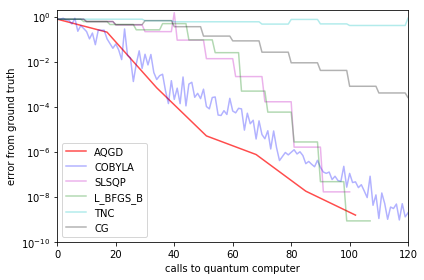

In [9]:
truth = -1.857275031
colors = ['r','b','m','g','c','k']

for j, opt in enumerate(['AQGD','COBYLA', 'SLSQP','L_BFGS_B','TNC','CG']):

    opt_res = results[opt]['run_0']
    x = [i for i, v in enumerate(opt_res['iteration_data'].values()) if (i%17==0 or opt != 'AQGD')]
    y = [v - truth for i, v in enumerate(opt_res['iteration_data'].values()) if (i%17==0 or opt != 'AQGD')]

    plt.plot(x, y, label = opt, color=colors[j], alpha = 0.7 if opt is 'AQGD' else 0.3) 

plt.xlim((0,120))
plt.ylim((1e-10, 2.))
plt.yscale('log')
plt.ylabel('error from ground truth')
plt.xlabel('calls to quantum computer')
plt.legend()
plt.tight_layout()